In [1]:
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import AutoMinorLocator
from scipy.optimize import curve_fit
plt.style.use('seaborn')
plt.style.use('matplotlibrc.py')

In [2]:
def get_Error(file_name,delay_days):
    #error analysis, where file_name is the name of the file to analyze
    #i dont include mypath as an arg bc it's a global variable
    file_dir = mypath + '/' + str(file_name)
    data = pd.read_csv(file_dir,sep=",",quotechar='"',parse_dates=["fecha"],na_values=[''])
    df = pd.DataFrame(data)
    df.sort_values(by=["fecha"])
    #dates formatting
    first_day = min(df["fecha"])
    last_day = max(df["fecha"])
    df["fecha"] -= first_day
    df.fecha = df.fecha.dt.days
    df = df.groupby(["fecha"], as_index=False).sum()
    df = df.to_numpy() #to numpy array (date,rho7d,inc14days,riskper10)
    #data analysis per se
    last = df.shape[0]
    df = np.hstack((df,np.zeros((last,1))))
    i = 19
    while i < last:
        df[i,4] = df[i-delay_days,3]
        i = i+1
    error = np.mean(abs(df[19:,4]-df[19:,2]))
    std = np.std(abs(df[19:,4]-df[19:,2]))/np.sqrt(df[19:,4].shape[0])
    #plt.title(file_name)
    #plt.plot(df[19:,4],'-ob')
    #plt.plot(df[19:,2])
    #plt.show()
    return error,std

In [3]:
#apparently theres like no function to make this thing i want
def make_hist(file_name,error,r_seven,bs,loc=2,save=False):
    error = error[:-10]
    r_seven = r_seven[:-10]
    error = abs(error)
    max_v = round(max(r_seven),1) 
    min_v = round(min(r_seven),1)
    r_bins = np.arange(min_v,max_v+bs,bs) #bin range
    rr_bins = np.arange(min_v,max_v+bs,bs*loc) #the loc factor comes into pay here
    n_size = r_bins.shape[0]-1 #amount of bins
    c_bins = np.zeros(n_size) #center of bins
    e_bins = np.zeros(n_size) #errors with same size
    std_bins = np.zeros(n_size) #std of bins 
    o_bins = np.zeros(n_size) #amount of observations for that bin
    i = 0 #this is just a counter
    #now we count for each bin based on error
    cuenta = 0
    while i < n_size:
        indices1 = ((i*bs)+min_v<=r_seven)
        indices2 = (r_seven < min_v + (i+1)*bs)
        indices = indices1*indices2
        errores = np.copy(error[indices])
        cuenta = errores.shape[0]
        if errores.size == 0:
            m_errores = 0
            m_std = 0
        else:
            m_errores = np.mean(errores)
            m_std = np.std(errores)/np.sqrt(errores.shape[0])
        e_bins[i] = m_errores
        std_bins[i] = m_std
        o_bins[i] = cuenta
        c_bins[i] = (2*i+1)*(bs/2) + min_v
        i = i +1
    plt.figure()
    plt.title(str(file_name)+' - Error-R7 - bs = 0.2')
    ax = plt.axes()
    ax.set_xticks(rr_bins)
    ax.set_xticklabels(())
    ax.set_xticklabels((rr_bins.round(2)))
    plt.xlabel(r'$R_7$',fontsize=12)
    plt.ylabel('Error',fontsize=12)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2)) #for minor ticks to be visible its the easiest i could find tbh
    plt.xticks(fontsize=12,rotation=90)
    plt.grid()
    plt.bar(c_bins, e_bins, bs, color='r',edgecolor='k',yerr=std_bins)
    #plt.savefig(str(file_name)+'_Hist_2.pdf')
    plt.show()
    return c_bins,e_bins,std_bins,o_bins

In [4]:
#grafico log-log
def graph_loglog(b_centers,b_errors):
    #save_data(b_centers,b_errors,c_obs,'BuenosAires_hist_2')
    b_centers = b_centers[b_errors!=0]
    b_errors = b_errors[b_errors!=0]
    max_errors = np.argmax(b_errors)
    max_rseven = b_centers[max_errors]
    print('R7 maximo: ',max_rseven)
    #separo a un lado
    b_centers_1 = b_centers[:max_errors]
    b_errors_1 = b_errors[:max_errors]
    #separo al otro lado
    b_centers_2 = b_centers[max_errors:]
    b_errors_2 = b_errors[max_errors:]
    #imprimo a ver si esta bien
    print(b_centers_1,b_centers_2)
    #grafico
    plt.scatter(np.log(np.abs(b_centers_1-1)),np.log(b_errors_1),label='left')
    plt.scatter(np.log(np.abs(b_centers_2-1)),np.log(b_errors_2),label='right')
    plt.xlabel(r'$log|R_7 - 1|, R_7 max = $'+str(max_rseven))
    plt.ylabel(r'log|Error|')
    plt.legend()
    plt.show()
    #plt.savefig('BuenosAires_2.pdf')

In [5]:
def save_data(b_centers,b_errors,c_obs,string):
    matriz = np.zeros((len(c_obs),3))
    matriz[:,0] = b_centers
    matriz[:,1] = b_errors
    matriz[:,2] = c_obs
    np.savetxt(string+'.txt',matriz,delimiter=',',header='Bin Centers,Abs Mean Error,Observations')

# grafico aca el tema de los errores - func de R7 (log-log)

In [6]:
def exponential(x,a,b):
    return a*(x**b)

# todos los graficos nuevos

# graficos por provincia primero

In [7]:
mypath = 'Datos_Provs' #archivos por provincia
files = [f for f in listdir(mypath) if isfile(join(mypath, f))] #archivos por localidad 
delay_days = [4,5,6,7,8]
len_days = len(delay_days)
len_files = len(files)
resultados = np.zeros((len_days,len_files))
resultados_std = np.zeros((len_days,len_files))
id_day = 0
localidades = ['BA','CABA','CH','CB','ER','JY','LR','MZ','NQ','RN','SA','SC','SF','TF','TU']
for delay_day in delay_days:
    id_file = 0
    for file in files:
        file_name = file
        error,std = get_Error(file_name,delay_day)
        resultados[id_day,id_file] = error
        resultados_std[id_day,id_file] = std
        id_file += 1
    id_day += 1

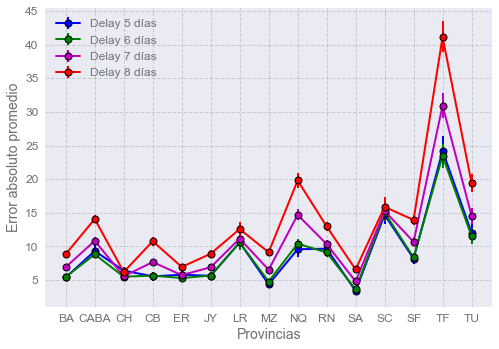

In [8]:
plt.errorbar(np.arange(len_files),resultados[1,:],yerr=resultados_std[0,:],fmt='-ob',label='Delay 5 días')
plt.errorbar(np.arange(len_files),resultados[2,:],yerr=resultados_std[1,:],fmt='-og',label='Delay 6 días')
plt.errorbar(np.arange(len_files),resultados[3,:],yerr=resultados_std[2,:],fmt='-om',label='Delay 7 días')
plt.errorbar(np.arange(len_files),resultados[4,:],yerr=resultados_std[3,:],fmt='-or',label='Delay 8 días')
plt.xticks(np.arange(len_files),labels=localidades)
plt.ylabel('Error absoluto promedio')
plt.xlabel('Provincias')
plt.legend(fontsize=12,loc='best')
plt.savefig('fig1.pdf',bbox_inches='tight')

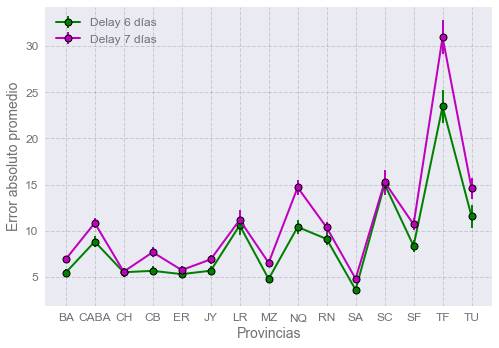

In [9]:
plt.errorbar(np.arange(len_files),resultados[2,:],yerr=resultados_std[1,:],fmt='-og',label='Delay 6 días')
plt.errorbar(np.arange(len_files),resultados[3,:],yerr=resultados_std[2,:],fmt='-om',label='Delay 7 días')
plt.xticks(np.arange(len_files),labels=localidades)
plt.ylabel('Error absoluto promedio')
plt.xlabel('Provincias')
plt.legend(fontsize=12,loc='best')
plt.savefig('fig2.pdf',bbox_inches='tight')

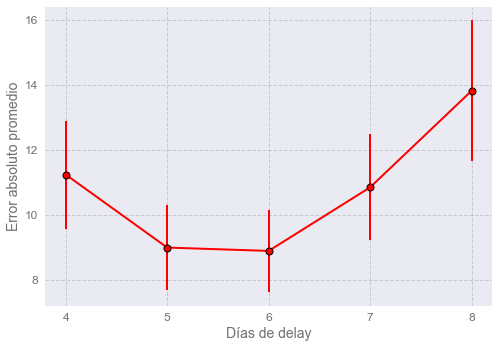

In [10]:
means = np.mean(resultados,axis=1)
eo_mean = np.std(resultados,axis=1)/np.sqrt(15)
plt.errorbar(delay_days,means,eo_mean,fmt='-or')
plt.xticks(np.arange(4,9))
plt.xlabel('Días de delay')
plt.ylabel('Error absoluto promedio')
plt.savefig('fig3.pdf',bbox_inches='tight')

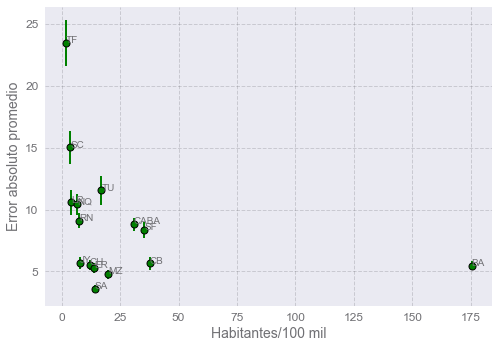

In [11]:
poblaciones = [17541141,3075646,1204541,3760450,1385961,770881,393531,1990338,664057,747610,1424397,365698,3536418,173432,1694656]
plt.errorbar(np.array(poblaciones)/100000,resultados[2,:],yerr=resultados_std[2,:],fmt='og',label='6 días')
plt.xlabel('Habitantes/100 mil')
plt.ylabel('Error absoluto promedio')
for i in np.arange(len(poblaciones)):
    plt.annotate(localidades[i], (poblaciones[i]/100000, resultados[2,i]))
plt.savefig('fig4.pdf',bbox_inches='tight')

# graficos por localidades + alguna provincia ahora

In [12]:
mypath = 'Datos_Loc' #archivos por provincia
files = [f for f in listdir(mypath) if isfile(join(mypath, f))] #archivos por localidad 
delay_days = [4,5,6,7,8]
len_days = len(delay_days)
len_files = len(files)
resultados = np.zeros((len_days,len_files))
resultados_std = np.zeros((len_days,len_files))
id_day = 0
localidades = ['AV','BB','BRC','CABA','CM8','CBC','GR','LM','MZC','SLC','ORAN','SFC','ROS','TUC']
for delay_day in delay_days:
    id_file = 0
    for file in files:
        file_name = file
        error,std = get_Error(file_name,delay_day)
        resultados[id_day,id_file] = error
        resultados_std[id_day,id_file] = std
        id_file += 1
    id_day += 1

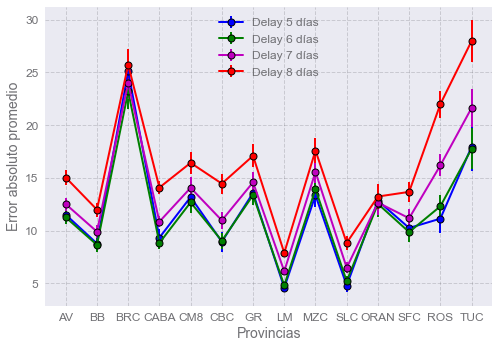

In [13]:
plt.errorbar(np.arange(len_files),resultados[1,:],yerr=resultados_std[0,:],fmt='-ob',label='Delay 5 días')
plt.errorbar(np.arange(len_files),resultados[2,:],yerr=resultados_std[1,:],fmt='-og',label='Delay 6 días')
plt.errorbar(np.arange(len_files),resultados[3,:],yerr=resultados_std[2,:],fmt='-om',label='Delay 7 días')
plt.errorbar(np.arange(len_files),resultados[4,:],yerr=resultados_std[3,:],fmt='-or',label='Delay 8 días')
plt.xticks(np.arange(len_files),labels=localidades)
plt.ylabel('Error absoluto promedio')
plt.xlabel('Provincias')
plt.legend(fontsize=12,loc='best')
plt.savefig('fig5.pdf',bbox_inches='tight')

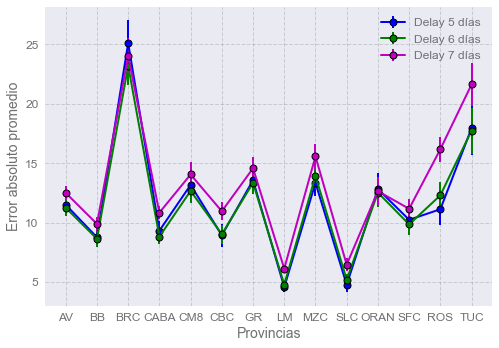

In [14]:
plt.errorbar(np.arange(len_files),resultados[1,:],yerr=resultados_std[0,:],fmt='-ob',label='Delay 5 días')
plt.errorbar(np.arange(len_files),resultados[2,:],yerr=resultados_std[1,:],fmt='-og',label='Delay 6 días')
plt.errorbar(np.arange(len_files),resultados[3,:],yerr=resultados_std[2,:],fmt='-om',label='Delay 7 días')
#plt.errorbar(np.arange(len_files),resultados[4,:],yerr=resultados_std[3,:],fmt='-or',label='8 días')
plt.xticks(np.arange(len_files),labels=localidades)
plt.ylabel('Error absoluto promedio')
plt.xlabel('Provincias')
plt.legend(fontsize=12,loc='best')
plt.savefig('fig6.pdf',bbox_inches='tight')

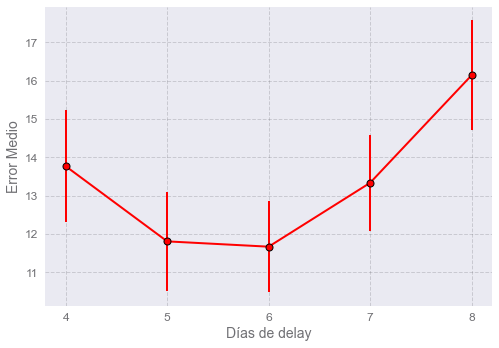

In [15]:
means = np.mean(resultados,axis=1)
eo_mean = np.std(resultados,axis=1)/np.sqrt(15)
plt.errorbar(delay_days,means,eo_mean,fmt='-or')
plt.xticks(np.arange(4,9))
plt.xlabel('Días de delay')
plt.ylabel('Error Medio')
plt.savefig('fig7.pdf',bbox_inches='tight')

In [16]:
poblaciones = [365771,310095,163743,3075646,228953,1453684,370245,2281194,119854,631058,162562,583368,1291010,605767]

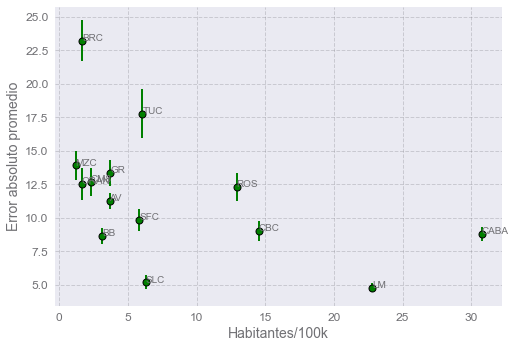

In [17]:
plt.errorbar(np.array(poblaciones)/100000,resultados[2,:],yerr=resultados_std[2,:],fmt='og',label='6 días')
plt.xlabel('Habitantes/100k')
plt.ylabel('Error absoluto promedio')
for i in np.arange(len(poblaciones)):
    plt.annotate(localidades[i], (poblaciones[i]/100000, resultados[2,i]))
plt.savefig('fig8.pdf',bbox_inches='tight')